In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

## Cargar el modelo victima

In [2]:
# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar estructura del modelo y adaptarla a 10 clases
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

# Cargar pesos
resnet50.load_state_dict(torch.load("CIFAR10_resnet50.pth", map_location=device))
resnet50 = resnet50.to(device)
resnet50.eval()


c:\Users\artur\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\artur\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\artur\AppData\Local\Temp\ipykernel_4524\3923808021.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future rel

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Cargar el dataset CIFAR10

In [3]:
transform = transforms.Compose([
    transforms.Resize(224),  # Importante para ResNet-50
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar dataset de prueba
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)

# Clases de CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Obtener un batch de 25 imágenes
dataiter = iter(loader)
images, labels = next(dataiter)

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data


## Visualizar el dataset CIFAR10



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


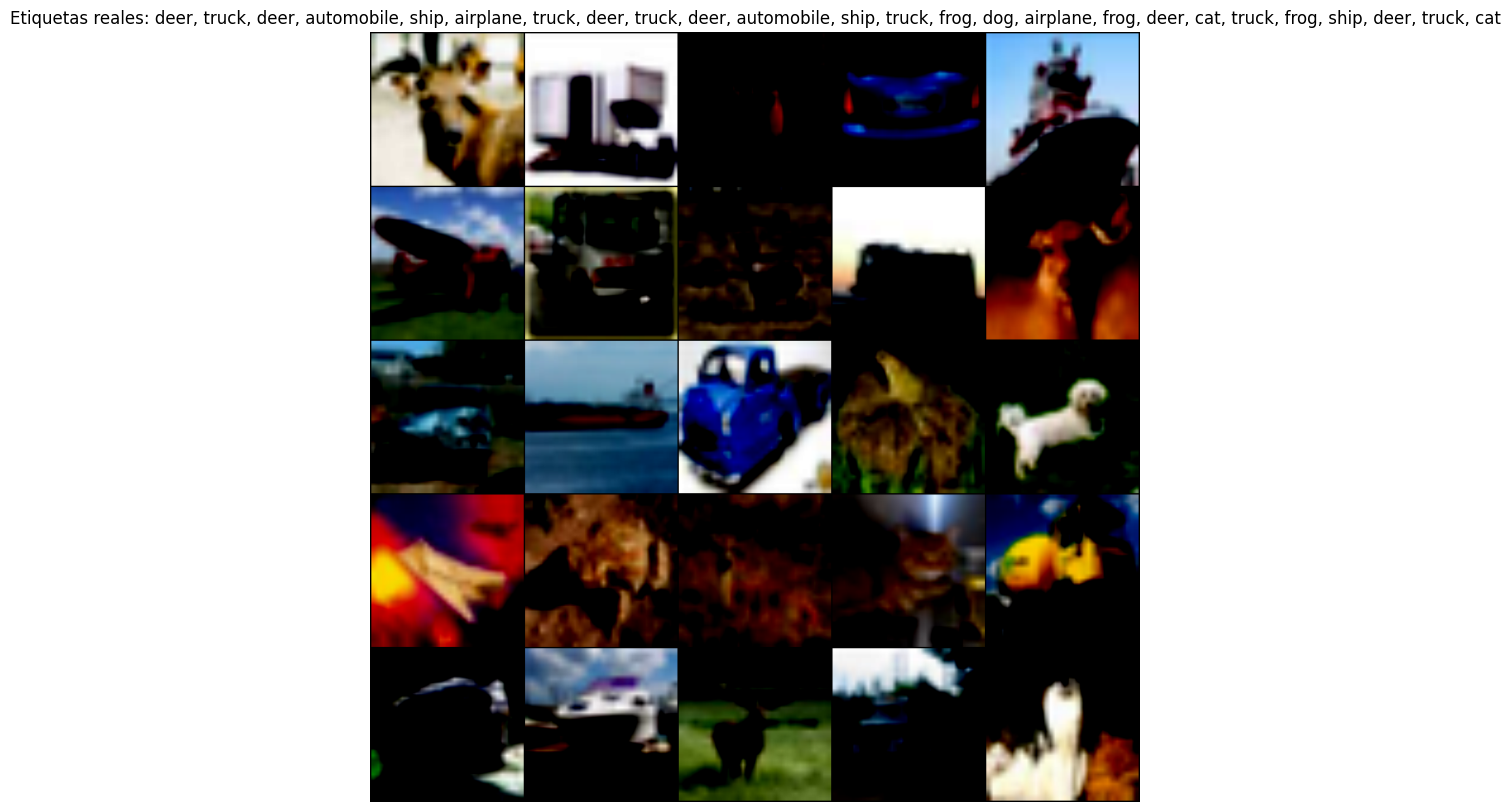

In [4]:
# Función para desnormalizar y mostrar una cuadrícula
def imshow(imgs, labels):
    imgs = torchvision.utils.make_grid(imgs, nrow=5, padding=2)
    npimg = imgs.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title("Etiquetas reales: " + ", ".join(classes[labels[i]] for i in range(25)))
    plt.show()

# Mostrar las imágenes
imshow(images, labels)

## PGD


In [ ]:
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=40):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    ori_images = images.clone().detach()

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = images.grad.data
        adv_images = images + alpha * grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach()

    return images


In [10]:
# Usar una imagen del conjunto de test
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=1, shuffle=True)
image, label = next(iter(testloader))
image, label = image.to(device), label.to(device)

# Generar imagen adversarial con PGD
resnet50.eval()
adv_image = pgd_attack(resnet50, image, label, eps=0.1, alpha=0.01, iters=10)

# Comparar predicción antes y después
with torch.no_grad():
    pred_orig = resnet50(image).argmax(dim=1).item()
    pred_adv = resnet50(adv_image).argmax(dim=1).item()

print(f"Etiqueta real: {label.item()}")
print(f"Predicción original: {pred_orig}")
print(f"Predicción adversarial (PGD): {pred_adv}")


Files already downloaded and verified
Etiqueta real: 1
Predicción original: 1
Predicción adversarial (PGD): 3


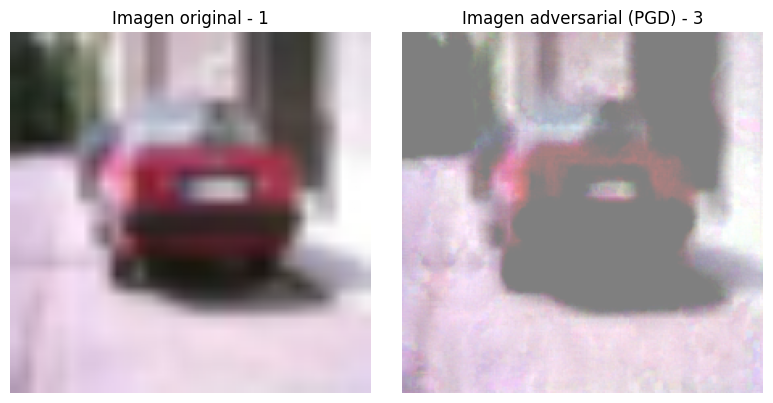

In [11]:
# Convertir a numpy para mostrar
def imshow(img, title):
    img = img.squeeze().detach().cpu().numpy()
    img = (img * 0.5) + 0.5  # desnormalizar si se normalizó con mean=0.5 std=0.5
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(np.clip(img, 0, 1))
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
imshow(image, f"Imagen original - {pred_orig}")

plt.subplot(1, 2, 2)
imshow(adv_image, f"Imagen adversarial (PGD) - {pred_adv}")

plt.tight_layout()
plt.show()

## Defensas frente a PGD

In [ ]:
# 1. Entrenamiento adversarial con PGD (modificado con bucle de épocas)
def train_adversarial_pgd(model, train_loader, optimizer, criterion, device, eps=0.1, alpha=0.01, iters=10, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            adv_data = pgd_attack(model, data, target, eps=eps, alpha=alpha, iters=iters)
            optimizer.zero_grad()
            output = model(adv_data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"[PGD-Epoch {epoch+1}] Loss: {running_loss / len(train_loader):.4f}")

# 2. Transformaciones defensivas para robustez
transform_defended = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader_defended = DataLoader(
    datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_defended),
    batch_size=64, shuffle=True
)

# 3. Entrenamiento adversarial robusto con PGD
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_adversarial_pgd(resnet50, train_loader_defended, optimizer, criterion, device, num_epochs=5)


Files already downloaded and verified
[PGD-Epoch 1] Loss: 1.6079
[PGD-Epoch 2] Loss: 1.4573
[PGD-Epoch 3] Loss: 1.6785
[PGD-Epoch 4] Loss: 1.3943
[PGD-Epoch 5] Loss: 1.4166


Files already downloaded and verified


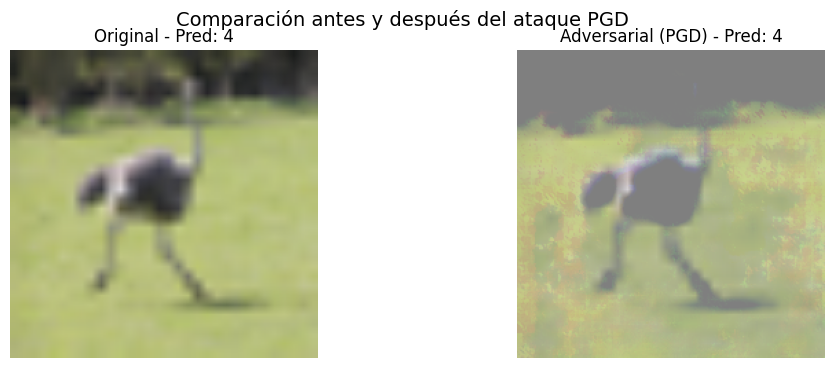

In [ ]:
# Usamos una imagen del conjunto de test
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=1, shuffle=True)
image, label = next(iter(testloader))
image, label = image.to(device), label.to(device)

# Aplicar ataque PGD
resnet50.eval()
adv_image = pgd_attack(resnet50, image, label, eps=0.1, alpha=0.01, iters=10)

# Predecir ambas
with torch.no_grad():
    pred_orig = resnet50(image).argmax(dim=1).item()
    pred_adv = resnet50(adv_image).argmax(dim=1).item()

# Visualización comparativa
def imshow(img_tensor, title):
    img = img_tensor.squeeze().detach().cpu().numpy()
    img = (img * 0.5) + 0.5
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
imshow(image, f"Original - Pred: {pred_orig}")
plt.subplot(1, 2, 2)
imshow(adv_image, f"Adversarial (PGD) - Pred: {pred_adv}")
plt.suptitle("Comparación antes y después del ataque PGD", fontsize=14)
plt.show()
